In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Data Preparation

In [2]:
DATA_PATH = "../../data/"

data = pd.read_excel(f"{DATA_PATH}df_filter_dummy_pohang.xlsx")

In [3]:
print(data.columns)
data.head(1)

Index(['Unnamed: 0', '뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2',
       '통합 분류3', '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관',
       '키워드', '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부', 'city',
       'filter_keyword', 'related_city', '인구', '도시', '도심', '지역', '지자체', ' 마을',
       '쇠퇴', '감소', '활성화', '도시발전', '지역발전', '혁신', '지역통합', '지역경제', '산업', '농업',
       '공업', '제조업', '서비스업', '경제활동', '사업체', '지역기업', '실업', '재정자립도', '지방세', '사업',
       '유치', '지역사회', '주민', '주민들', '지역주민', '주민생활', '지역복지', '지역대학', '관광', '지역문화',
       '지역축제', '국제', '개최', '체험', '고령화', '의료', '지역환경', '환경오염', '환경문제', '도시환경',
       '생활환경', '피해', '발생', '기존주택', '노후주택', '노후아파트', '빈집', '공가', ' 폐가', '공공시설',
       '생활시설', '기반시설', '인프라', '재개발', '재건축', '공동화', '조성', '건설', '공원화'],
      dtype='object')


,Unnamed: 0,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,...,공공시설,생활시설,기반시설,인프라,재개발,재건축,공동화,조성,건설,공원화
0,472528,1100901.200112,20011231,중앙일보,송봉근\n기자,[2001 사라져 버린 것들] 단성사 등 추억 속으로,지역>경남,지역>부산,지역>전북,NaN,...,0,0,0,0,0,1,0,0,0,0


In [4]:
keyword_set = data['filter_keyword']

In [5]:
key_set = []
for item in keyword_set:
    item = item.replace("{", "")
    item = item.replace("}", "")
    item = item.replace("'", "")
    splited = item.split(",")
    temp = []
    for tok in splited:
        temp.append(tok.replace(" ", ""))
    key_set.append(temp)

### Apriori algorithm

In [6]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [7]:
te = TransactionEncoder()
te_result = te.fit(key_set).transform(key_set)

In [8]:
key_df = pd.DataFrame(te_result, columns=te.columns_)

In [9]:
itemset = apriori(key_df, min_support=0.01, use_colnames=True)

In [10]:
itemset

,support,itemsets
0,0.038140,(감소)
1,0.117740,(개최)
2,0.116447,(건설)
3,0.010058,(공공시설)
4,0.070405,(관광)
...,...,...
328,0.016188,"(조성, 지역, 산업, 유치)"
329,0.011048,"(조성, 지역, 인프라, 산업)"
330,0.016268,"(주민, 주민들, 피해, 지역)"
331,0.013698,"(조성, 지역, 산업, 사업, 도시)"


In [11]:
from mlxtend.frequent_patterns import association_rules
apriori_result = association_rules(itemset, metric="lift", min_threshold=1)

In [12]:
network_data = apriori_result[['antecedents', 'consequents', 'lift']]

In [13]:
network_data

,antecedents,consequents,lift
0,(사업),(감소),1.193899
1,(감소),(사업),1.193899
2,(감소),(지역),1.154597
3,(지역),(감소),1.154597
4,(개최),(관광),1.802657
...,...,...,...
1551,(조성),"(사업, 지역, 산업, 유치)",3.562996
1552,(지역),"(사업, 조성, 산업, 유치)",1.275293
1553,(산업),"(사업, 지역, 조성, 유치)",4.490781
1554,(유치),"(사업, 지역, 조성, 산업)",3.982889


### Visualize network

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

Duplicate key in file PosixPath('/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  NanumGothic')


In [24]:
import matplotlib
import matplotlib.font_manager

[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]

[]

In [25]:
np.mean(network_data['lift'])

2.5184692137761298

In [26]:
node_lst = []
for node in network_data['antecedents']:
    node_lst.append(', '.join(list(node)))

In [27]:
graph = nx.Graph()
graph.add_nodes_from(node_lst)
for i in range(len(network_data)):
    a, b, c = network_data.iloc[i, :]
    a = ', '.join(list(a))
    b = ', '.join(list(b))
    if c > 1:
        graph.add_edge(a, b, weight = c)
    else:
        pass

In [28]:
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=18)

In [29]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_list

['/usr/share/fonts/truetype/lohit-telugu/Lohit-Telugu.ttf',
 '/usr/share/fonts/truetype/kacst/KacstFarsi.ttf',
 '/usr/share/fonts/truetype/kacst/KacstPoster.ttf',
 '/usr/share/fonts/truetype/freefont/FreeSerifBoldItalic.ttf',
 '/usr/share/fonts/truetype/tlwg/Kinnari-BoldOblique.ttf',
 '/usr/share/fonts/truetype/tibetan-machine/TibetanMachineUni.ttf',
 '/usr/share/fonts/truetype/tlwg/Purisa-BoldOblique.ttf',
 '/usr/share/fonts/truetype/lao/Phetsarath_OT.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgTypewriter-Bold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed.ttf',
 '/usr/share/fonts/truetype/malayalam/Dyuthi.ttf',
 '/usr/share/fonts/truetype/fonts-deva-extra/samanata.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
 '/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc',
 '/usr/share/fonts/truetype/fonts-guru-extra/Saab.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',
 '/usr/share/fonts/truetype/freefont/FreeMonoOblique.ttf',
 '/usr/share/fonts/truetype/fon

In [30]:
f = [f.name for f in fm.fontManager.ttflist]
f

['STIXSizeFiveSym',
 'STIXSizeFourSym',
 'DejaVu Serif',
 'cmtt10',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'cmr10',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'STIXSizeThreeSym',
 'DejaVu Sans',
 'STIXGeneral',
 'DejaVu Sans Display',
 'DejaVu Sans',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'STIXNonUnicode',
 'DejaVu Serif',
 'STIXSizeFourSym',
 'cmb10',
 'STIXSizeTwoSym',
 'cmsy10',
 'STIXNonUnicode',
 'STIXSizeThreeSym',
 'DejaVu Serif Display',
 'DejaVu Sans Mono',
 'STIXSizeOneSym',
 'cmss10',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'DejaVu Serif',
 'cmmi10',
 'STIXNonUnicode',
 'cmex10',
 'Waree',
 'Purisa',
 'Norasi',
 'Lohit Gurmukhi',
 'KacstNaskh',
 'FreeMono',
 'Lohit Malayalam',
 'FreeSans',
 'Gargi',
 'Loma',
 'Tlwg Typewriter',
 'Noto Sans CJK JP',
 'KacstFarsi',
 'KacstLetter',
 'KacstTitleL',
 'Ubuntu',
 'Lohit Devanagari',
 'FreeSans',
 'Phetsarath OT',
 'Ubuntu',
 'Laksaman',
 'Karumbi',
 'DejaVu Sans',
 'Suruma

In [35]:
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Gothic' in f.name]

[]

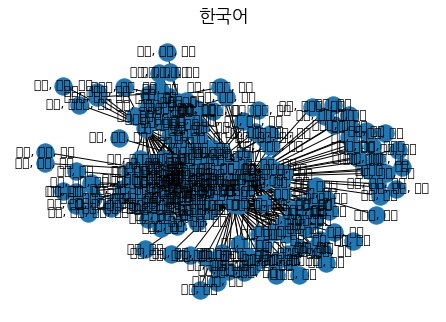

In [23]:
from matplotlib.font_manager import FontProperties


pos = nx.shell_layout(graph)
#nx.draw_networkx_labels(graph, pos, font_size=15, font_family=font_name)
nx.draw(graph, with_labels = True)
plt.title("한국어", fontproperties = fontprop)
plt.show()